In [127]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PyWGCNA
import plotly.express as px
import math

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from matplotlib import pyplot as plt


In [128]:
def plotDispEsts(dds):
    '''
    Params
        dds: a DESeqDataSet with dispersions estimated

    '''
    plt.rcParams.update({'font.size': 6})

    plt.figure(figsize=(3,3),dpi=300)
    plt.scatter(x=dds.varm['_normed_means'],y=dds.varm['genewise_dispersions'],c='black',alpha=0.5,s=0.4)
    plt.scatter(x=dds.varm['_normed_means'],y=dds.varm['dispersions'],c='royalblue',alpha=0.5,s=0.4) 
    plt.scatter(x=dds.varm['_normed_means'],y=dds.varm['fitted_dispersions'],c='red',alpha=0.5,s=0.4) 

    plt.yscale('log')
    plt.xscale('log')
    plt.legend(['Estimated','Final','Fitted'],loc='best')
    plt.xlabel('mean of normalized counts')
    plt.ylabel('dispersion')
    plt.show()
    

In [147]:
def plotMA(results_df):
    #results_df = results_df.copy(deep=True)
    results_df.loc[results_df['padj'] <= 0.05, 'color'] = 'darkred'
    results_df.loc[results_df['padj'] > 0.05, 'color'] = 'gray'
    results_df.loc[results_df['padj'].isna(), 'color'] = 'gray'

    fig, ax = plt.subplots(figsize=(3,3),dpi=600)
    
    plt.scatter(x=results_df['baseMean'],
                y=results_df['log2FoldChange'],
                c=list(results_df['color'].values),
                s=0.2,
                )
    ax.set_adjustable("datalim")
    plt.xscale('log')
    plt.xlabel('mean of normalized counts')
    plt.ylabel('log fold change')
    
    plt.axhline(0,color='red',alpha=0.5,linestyle='--',zorder=3)
    plt.show()
    fig.show()

In [129]:
data = pd.read_table('/Users/erin/git/bioinformatics_scripting/python/pydeseq2_testing/data/Mov10_full_counts.txt',index_col=[0])
meta = pd.read_table('/Users/erin/git/bioinformatics_scripting/python/pydeseq2_testing/meta/Mov10_full_meta.txt',index_col=[0])

In [130]:
data.head()

,Mov10_kd_2,Mov10_kd_3,Mov10_oe_1,Mov10_oe_2,Mov10_oe_3,Irrel_kd_1,Irrel_kd_2,Irrel_kd_3
GeneSymbol,,,,,,,,
1/2-SBSRNA4,57,41,64,55,38,45,31,39
A1BG,71,40,100,81,41,77,58,40
A1BG-AS1,256,177,220,189,107,213,172,126
A1CF,0,1,1,0,0,0,0,0
A2LD1,146,81,138,125,52,91,80,50


In [131]:
meta.head()

,sampletype,MOVexpr
Mov10_kd_2,MOV10_knockdown,low
Mov10_kd_3,MOV10_knockdown,low
Mov10_oe_1,MOV10_overexpression,high
Mov10_oe_2,MOV10_overexpression,high
Mov10_oe_3,MOV10_overexpression,high


In [132]:
counts = data.T.reindex(meta.index)

In [133]:
counts.head()

GeneSymbol,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
Mov10_kd_2,57,71,256,0,146,10,3,0,56,0,...,6771,308,1155,4578,1072,4628,5296,4353,3401,1
Mov10_kd_3,41,40,177,1,81,9,2,0,37,0,...,4121,204,602,2778,678,2817,2982,2358,2006,1
Mov10_oe_1,64,100,220,1,138,2,6,2,107,0,...,4603,362,1027,4478,991,3406,3244,2482,2514,0
Mov10_oe_2,55,81,189,0,125,5,5,1,118,0,...,4293,317,945,3911,920,3072,3485,1991,2236,0
Mov10_oe_3,38,41,107,0,52,2,2,3,65,1,...,2561,219,592,2412,588,2049,1596,1114,1466,0


In [134]:
genes_to_keep = counts.columns[counts.sum(axis=0) >= 10]
counts = counts[genes_to_keep]

In [135]:
meta

,sampletype,MOVexpr
Mov10_kd_2,MOV10_knockdown,low
Mov10_kd_3,MOV10_knockdown,low
Mov10_oe_1,MOV10_overexpression,high
Mov10_oe_2,MOV10_overexpression,high
Mov10_oe_3,MOV10_overexpression,high
Irrel_kd_1,control,normal
Irrel_kd_2,control,normal
Irrel_kd_3,control,normal


In [136]:
#R
#dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ sampletype)

dds = DeseqDataSet(
    counts=counts,
    clinical=meta,
    design_factors=['sampletype'],
    refit_cooks=True,
    n_cpus=8,
)

In [137]:
#r
#dds <- DESeq(dds)

dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.74 seconds.

Fitting dispersion trend curve...
... done in 5.32 seconds.

Fitting MAP dispersions...
... done in 10.78 seconds.

Fitting LFCs...
... done in 6.24 seconds.

Refitting 0 outliers.



In [138]:
dds.design_factors

['sampletype']

In [139]:
stat_res = DeseqStats(dds, n_cpus=8, contrast=["sampletype", "MOV10_overexpression", "MOV10_knockdown"])


In [140]:
stat_res.summary()

Running Wald tests...
... done in 2.23 seconds.

Log2 fold change & Wald test p-value: sampletype MOV10_overexpression vs MOV10_knockdown


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneSymbol,,,,,,
1/2-SBSRNA4,45.652040,0.420106,0.280568,1.497339,1.343050e-01,2.099951e-01
A1BG,61.093102,0.735045,0.247326,2.971966,2.958993e-03,7.875389e-03
A1BG-AS1,175.665807,-0.020977,0.147141,-0.142563,8.866352e-01,9.187942e-01
A2LD1,89.617985,0.200929,0.203555,0.987099,3.235939e-01,4.293967e-01
A2M,5.860084,-1.368770,0.803664,-1.703162,8.853775e-02,1.492095e-01
...,...,...,...,...,...,...
ZYG11A,746.137934,0.264957,0.082472,3.212699,1.314940e-03,3.838596e-03
ZYG11B,2973.949477,-0.042748,0.065556,-0.652088,5.143446e-01,6.163107e-01
ZYX,2933.105330,-0.254442,0.079269,-3.209857,1.328012e-03,3.871044e-03


In [141]:
stat_res.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneSymbol,,,,,,
1/2-SBSRNA4,45.652040,0.420106,0.280568,1.497339,1.343050e-01,2.099951e-01
A1BG,61.093102,0.735045,0.247326,2.971966,2.958993e-03,7.875389e-03
A1BG-AS1,175.665807,-0.020977,0.147141,-0.142563,8.866352e-01,9.187942e-01
A2LD1,89.617985,0.200929,0.203555,0.987099,3.235939e-01,4.293967e-01
A2M,5.860084,-1.368770,0.803664,-1.703162,8.853775e-02,1.492095e-01
...,...,...,...,...,...,...
ZYG11A,746.137934,0.264957,0.082472,3.212699,1.314940e-03,3.838596e-03
ZYG11B,2973.949477,-0.042748,0.065556,-0.652088,5.143446e-01,6.163107e-01
ZYX,2933.105330,-0.254442,0.079269,-3.209857,1.328012e-03,3.871044e-03


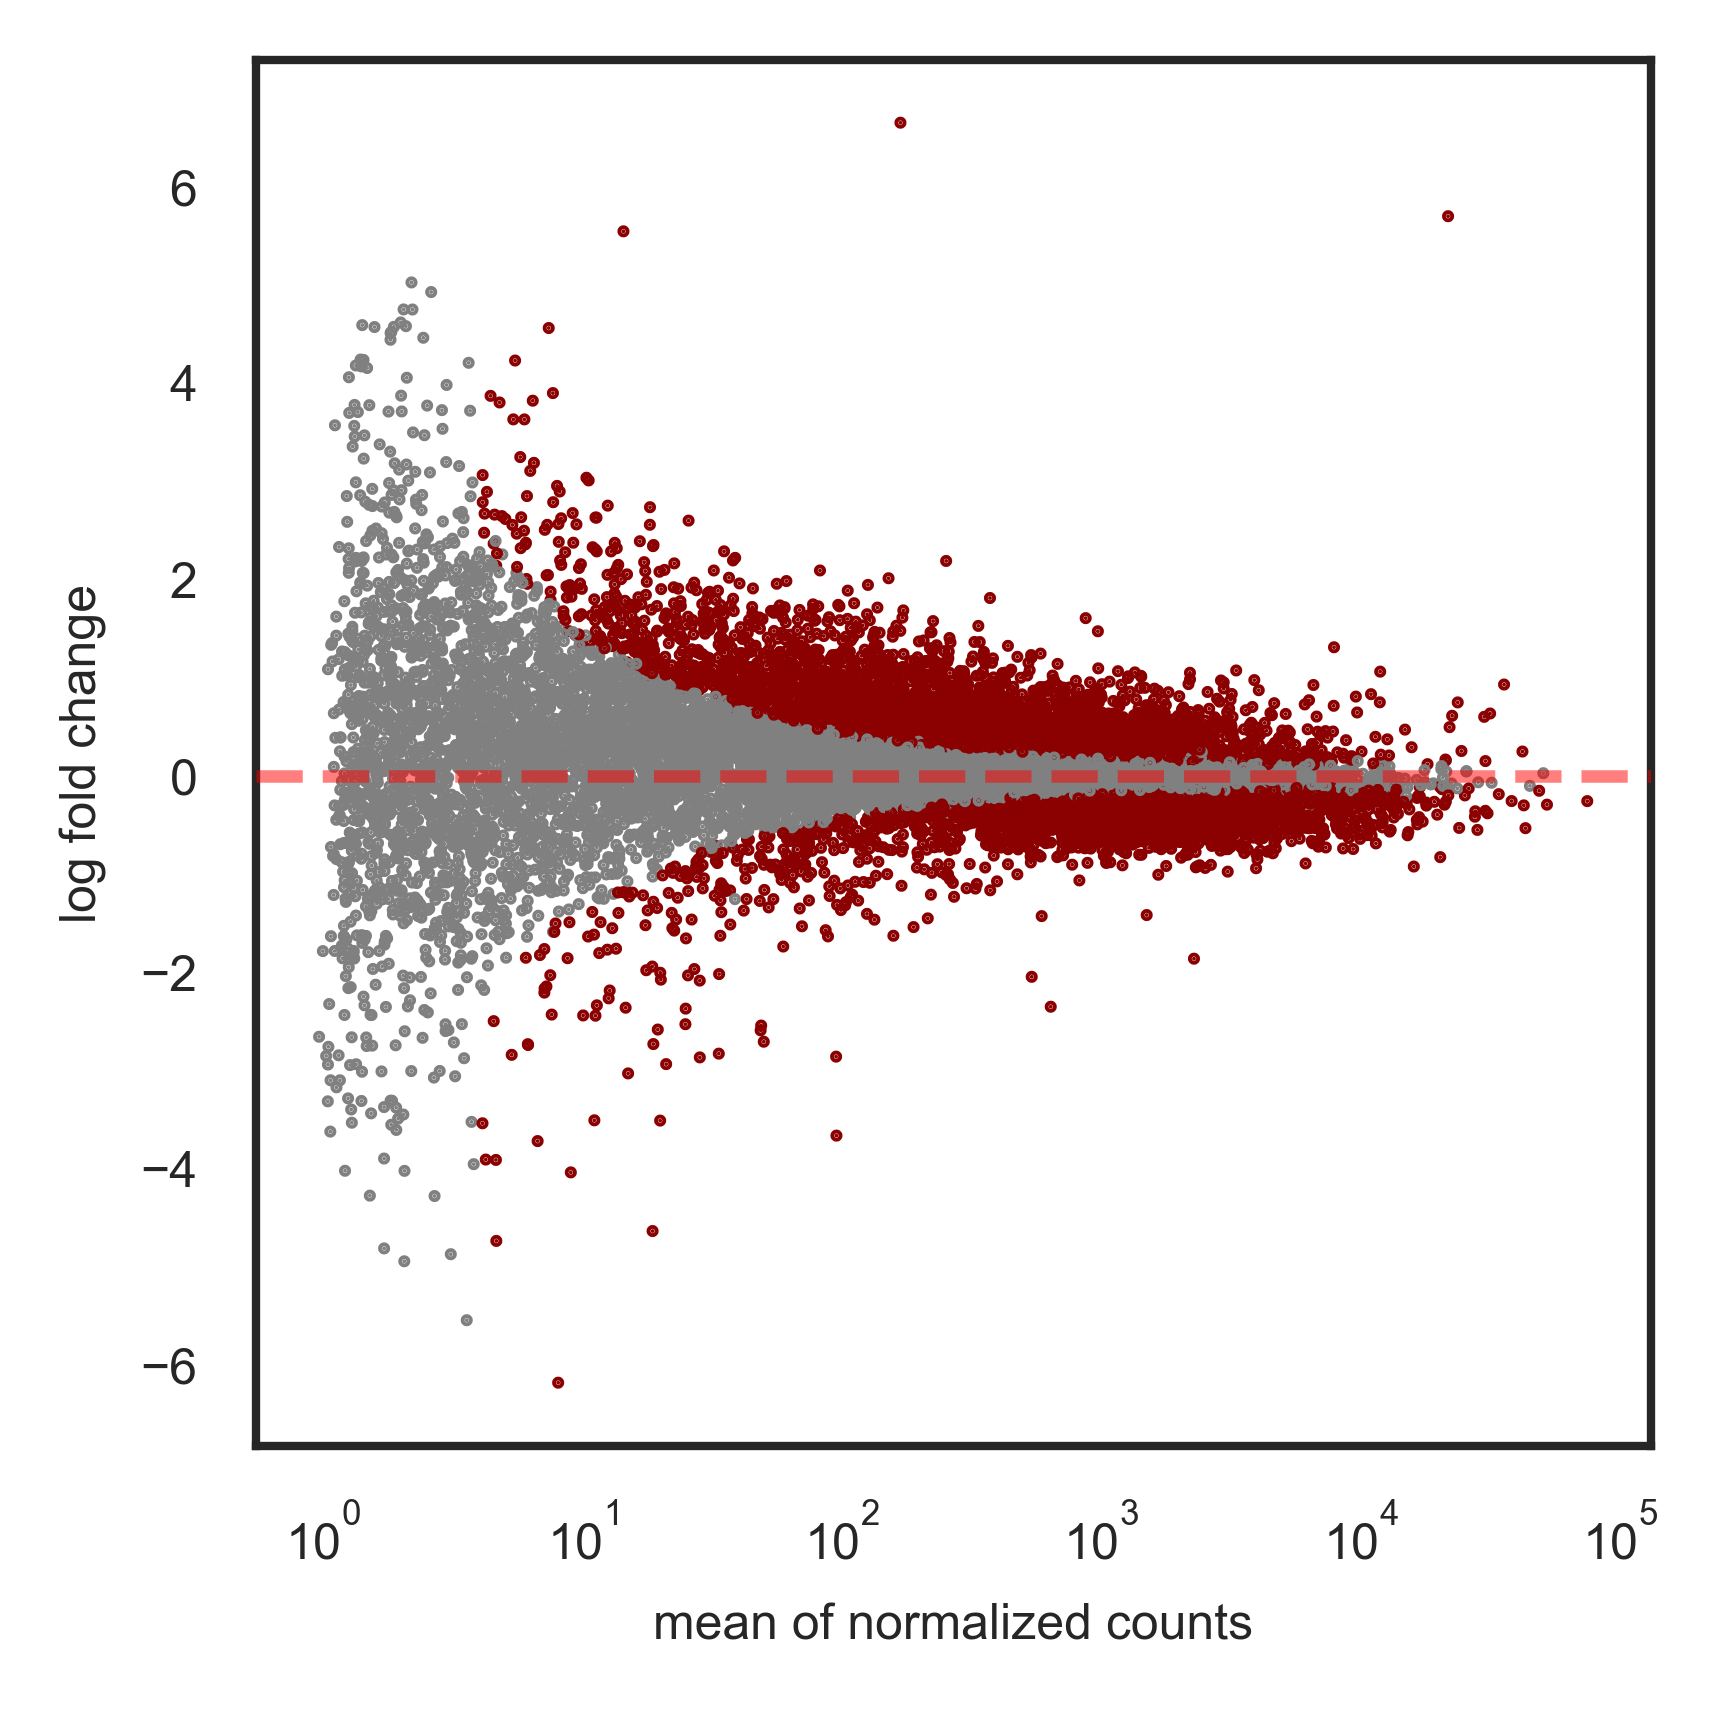

In [148]:
plotMA(stat_res.results_df)

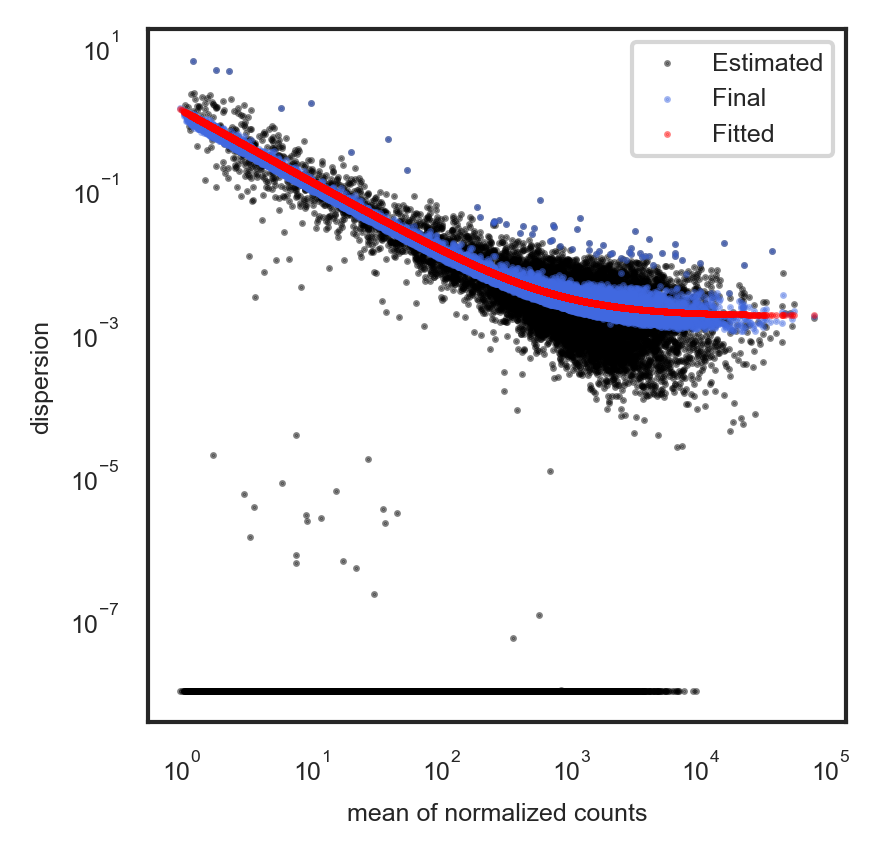

In [144]:
#Each black dot is a gene with an associated mean expression level 
#and maximum likelihood estimation (MLE) of the dispersion (Step 1).

#PyDESeq2 --> dds.varm['genewise_dispersions'] are MLE

plotDispEsts(dds)

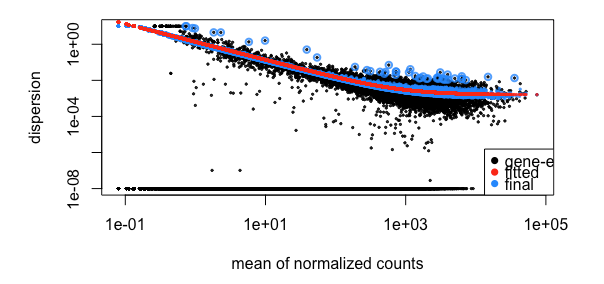